### Importing Necessary Libraries

In [80]:
import ast
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Resizing, Conv2D, Dropout, Flatten, Dense , Input , Resizing , GlobalAveragePooling2D , BatchNormalization , MaxPooling2D ,Activation,SpatialDropout2D, Lambda
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import cv2

In [81]:
df = pd.read_csv('master_doodle_dataframe.csv')

In [82]:
df.head(5)

,countrycode,drawing,key_id,recognized,word,image_path
0,RO,"[[[0, 5, 3, 4, 10, 72, 82, 91, 99, 98, 87, 71,...",5613582005829632,True,traffic light,data/traffic light/5613582005829632.png
1,US,"[[[0, 255], [3, 4]], [[86, 73, 73, 76, 85, 130...",5769631006457856,True,traffic light,data/traffic light/5769631006457856.png
2,ZA,"[[[39, 33, 34, 39, 52, 61, 66, 65, 67, 71], [2...",4999795544424448,True,traffic light,data/traffic light/4999795544424448.png
3,VN,"[[[12, 9], [128, 255]], [[0, 23, 36, 37, 42, 5...",4878417906368512,True,traffic light,data/traffic light/4878417906368512.png
4,HU,"[[[9, 7, 0, 19, 49, 90, 96, 99, 93, 94, 62, 16...",5572841187573760,True,traffic light,data/traffic light/5572841187573760.png


In [83]:
df.columns

Index(['countrycode', 'drawing', 'key_id', 'recognized', 'word', 'image_path'], dtype='object')

In [84]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [85]:
df = df[['drawing','word']]

In [86]:
df.head() #drawing is currently in the form of strokes D:

,drawing,word
0,"[[[0, 5, 3, 4, 10, 72, 82, 91, 99, 98, 87, 71,...",traffic light
1,"[[[0, 255], [3, 4]], [[86, 73, 73, 76, 85, 130...",traffic light
2,"[[[39, 33, 34, 39, 52, 61, 66, 65, 67, 71], [2...",traffic light
3,"[[[12, 9], [128, 255]], [[0, 23, 36, 37, 42, 5...",traffic light
4,"[[[9, 7, 0, 19, 49, 90, 96, 99, 93, 94, 62, 16...",traffic light


In [87]:
words = df['word'].unique()
words

array(['traffic light', 'rhinoceros', 'bed', 'school bus', 'van',
       'octopus', 'firetruck', 'laptop', 'tractor', 'matches', 'windmill',
       'square', 'pineapple', 'candle', 'mosquito', 'pear', 'boomerang',
       'lollipop', 'yoga', 'waterslide', 'swan', 'triangle',
       'diving board', 'crayon', 'hockey puck', 'moustache', 'calendar',
       'cow', 'fire hydrant', 'hot air balloon', 'helmet', 'parrot',
       'hot tub', 'baseball', 'saw', 'mouth', 'passport', 'campfire',
       'car', 'bulldozer', 'pencil', 'wine glass', 'marker', 'axe', 'mug',
       'see saw', 'foot', 'door', 'beach', 'cruise ship', 'drums',
       'necklace', 'spoon', 'motorbike', 'megaphone', 'penguin',
       'washing machine', 'giraffe', 'monkey', 'shoe', 'microphone',
       'skyscraper', 'blackberry', 'sword', 'nail', 'birthday cake',
       'carrot', 'lobster', 'hourglass', 'microwave', 'cannon',
       'clarinet', 'basketball', 'pliers', 'bee', 'flashlight', 'leaf',
       'belt', 'grass', 'river',

In [88]:
df_1000_per_class = df.groupby("word").apply(lambda x: x.sample(n=min(len(x), 3000))).reset_index(drop=True)

C:\Users\bette\AppData\Local\Temp\ipykernel_16244\3420098130.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_1000_per_class = df.groupby("word").apply(lambda x: x.sample(n=min(len(x), 3000))).reset_index(drop=True)


In [89]:
df_1000_per_class

,drawing,word
0,"[[[10, 27, 56, 76, 98, 113, 126, 142, 148, 147...",The Eiffel Tower
1,"[[[0, 18, 56, 78, 101, 105, 118, 127, 140], [2...",The Eiffel Tower
2,"[[[73, 72, 65, 42, 1, 21], [0, 53, 105, 168, 2...",The Eiffel Tower
3,"[[[0, 9, 18, 41, 45, 49, 87, 151, 153, 152, 16...",The Eiffel Tower
4,"[[[50, 35, 22, 15, 0], [6, 78, 112, 192, 244]]...",The Eiffel Tower
...,...,...
1019995,"[[[0, 48, 93, 164, 194, 206, 235, 255], [90, 2...",zigzag
1019996,"[[[75, 122, 222, 211, 1, 229, 135, 35, 32, 38,...",zigzag
1019997,"[[[101, 68, 0, 127, 142, 140, 129, 97, 54, 2, ...",zigzag
1019998,"[[[0, 18, 79, 106, 136, 150, 151, 132, 118, 10...",zigzag


In [90]:
words_unique = df_1000_per_class['word'].drop_duplicates().sample(n=50,random_state=21)
print(words_unique)

963000          truck
390000    garden hose
165000       calendar
216000         church
177000       campfire
540000         marker
183000         cannon
810000      snowflake
684000           pond
909000      telephone
846000           star
153000      butterfly
279000            dog
273000     dishwasher
387000         garden
627000          pants
531000       lollipop
960000       trombone
477000         jacket
648000           peas
990000     waterslide
426000     headphones
510000     light bulb
798000    smiley face
546000      megaphone
135000       broccoli
864000          stove
27000           anvil
339000          fence
291000         dragon
18000           angel
450000       hospital
882000            sun
258000      crocodile
72000           beach
570000       mountain
12000     alarm clock
855000    stethoscope
429000       hedgehog
729000          river
468000    house plant
156000         cactus
597000          ocean
924000        toaster
357000       flamingo
588000    

In [91]:
dfmain = df_1000_per_class[df_1000_per_class['word'].isin(words_unique)]

In [92]:
type(dfmain)

pandas.core.frame.DataFrame

In [93]:
dfmain = dfmain.reset_index(drop=True)

In [94]:
dfmain

,drawing,word
0,"[[[69, 112, 129, 160, 183, 203, 213, 218, 220,...",alarm clock
1,"[[[92, 74, 61, 45, 39, 38, 41, 64, 88, 117, 14...",alarm clock
2,"[[[69, 62, 44, 7, 0, 7, 20, 45, 96, 139, 163, ...",alarm clock
3,"[[[76, 78, 96, 104, 114, 137, 154, 168, 171], ...",alarm clock
4,"[[[116, 121, 153, 168, 179, 193, 197, 197, 183...",alarm clock
...,...,...
149995,"[[[21, 13, 2, 0, 2], [1, 160, 228, 255, 248]],...",waterslide
149996,"[[[3, 11, 15], [237, 148, 42]], [[30, 48, 45],...",waterslide
149997,"[[[34, 69, 88, 108, 111, 111, 98, 73, 38, 11, ...",waterslide
149998,"[[[0, 3], [108, 104]], [[28, 38, 47, 72], [93,...",waterslide


In [95]:
dfmain['word'].unique()

array(['alarm clock', 'angel', 'anvil', 'bandage', 'beach', 'broccoli',
       'butterfly', 'cactus', 'calendar', 'campfire', 'cannon', 'church',
       'crocodile', 'dishwasher', 'dog', 'door', 'dragon', 'fence',
       'flamingo', 'garden', 'garden hose', 'headphones', 'hedgehog',
       'hospital', 'house plant', 'jacket', 'light bulb', 'lollipop',
       'marker', 'megaphone', 'mountain', 'nail', 'ocean', 'pants',
       'peas', 'pond', 'rainbow', 'river', 'smiley face', 'snowflake',
       'stairs', 'star', 'stethoscope', 'stove', 'sun', 'telephone',
       'toaster', 'trombone', 'truck', 'waterslide'], dtype=object)

### Unused commands are commented // Cell for conversion of strokes to image

In [96]:
#def makeimage(strokes , image_size = 96  , line_width = 2): 
    #img = Image.new("L", (image_size, image_size), color=255) 
    #draw = ImageDraw.Draw(img)
    
    #for stroke in strokes:
        #x, y = stroke
        #points = list(zip(x, y))
        #draw.line(points, fill=0, width=line_width)
    #return np.array(img)

def draw_strokes(strokes, size=96, lw=3):
    img = np.zeros((256, 256), np.uint8)  
    for stroke in strokes:
        for i in range(len(stroke[0]) - 1):
            x1, y1 = stroke[0][i], stroke[1][i]
            x2, y2 = stroke[0][i+1], stroke[1][i+1]
            cv2.line(img, (x1, y1), (x2, y2), color=255, thickness=lw)

    if img.max() > 0:
        x, y, w, h = cv2.boundingRect((img > 0).astype(np.uint8))
        img = img[y:y+h, x:x+w]
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

    return img

In [97]:
dfmain['image'] = dfmain['drawing'].apply(lambda x: 255 - draw_strokes(eval(x)))

In [98]:
dfmain.head(5)

,drawing,word,image
0,"[[[69, 112, 129, 160, 183, 203, 213, 218, 220,...",alarm clock,"[[255, 255, 255, 223, 0, 0, 134, 96, 17, 0, 0,..."
1,"[[[92, 74, 61, 45, 39, 38, 41, 64, 88, 117, 14...",alarm clock,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,"[[[69, 62, 44, 7, 0, 7, 20, 45, 96, 139, 163, ...",alarm clock,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,"[[[76, 78, 96, 104, 114, 137, 154, 168, 171], ...",alarm clock,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,"[[[116, 121, 153, 168, 179, 193, 197, 197, 183...",alarm clock,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [99]:
dfmain['image'][0].shape

(96, 96)

In [100]:
dfmain.shape

(150000, 3)

In [101]:
dfmain = dfmain.drop('drawing',axis=1)

In [102]:
dfmain.head()
X = np.stack(dfmain['image'].values)
X = X.astype(np.float32) / 255.0
y = dfmain['word']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Unused commands are kept in a markdown cell (previous testing)

ds = tf.data.Dataset.from_tensor_slices((X, y))
ds = ds.shuffle(buffer_size=1000)  # shuffle with buffer size of 1000

def train_test_val_func(data , train_size , test_size , val_size):
    lengthdata = len(data)
    trainds = data.take(int(train_size*lengthdata))
    leftover = data.skip(int(train_size*lengthdata))
    valds = leftover.take(int(val_size*lengthdata))
    testds = leftover.skip(int(val_size*lengthdata))
    return trainds , testds , valds

trainds , testds , valds = train_test_val_func(ds,0.80,0.10,0.10) 

trainds = trainds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
testds = testds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
valds = valds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

X = dfmain['image']
X = X / 255.0
X= X.astype('float32')
y = dfmain['word']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [103]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_stacked = np.stack(X_train, axis=0)
X_train_ready = np.expand_dims(X_train_stacked, axis=-1)
X_train = X_train_ready
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_val_stacked = np.stack(X_val, axis=0)
X_val_ready = np.expand_dims(X_val_stacked, axis=-1)
X_val = X_val_ready
X_test_stacked = np.stack(X_test, axis=0)
X_test_ready = np.expand_dims(X_test_stacked, axis=-1)
X_test = X_test_ready

In [110]:
inputs = Input(shape=(96, 96, 1))
x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False

#for layer in base_model.layers[:-20]:
#    layer.trainable = False

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(50, activation='softmax')(x)

In [111]:
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 lambda_3 (Lambda)           (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 512)               655872    
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048

In [112]:
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=10,             
    restore_best_weights=True, 
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      
    factor=0.2,              
    patience=5,              
    min_lr=0.00001,          
    verbose=1                
)

In [113]:
batch_size =32
def data_generator():
    for i in range(0, len(X_train), batch_size):
        yield X_train[i:i+batch_size], y_train[i:i+batch_size]

train_ds = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32),  
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

train_ds = train_ds.shuffle(buffer_size=10).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Model Training

In [115]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, 
          epochs=15,
          validation_data=val_ds,
          callbacks=[early_stopping, reduce_lr], 
          verbose=1,
          batch_size=64
         )

Epoch 1/15
3750/3750 [==============================] - 154s 39ms/step - loss: 0.8345 - accuracy: 0.7587 - val_loss: 0.6105 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 2/15
3750/3750 [==============================] - 140s 37ms/step - loss: 0.7633 - accuracy: 0.7801 - val_loss: 0.5810 - val_accuracy: 0.8296 - lr: 0.0010
Epoch 3/15
3750/3750 [==============================] - 144s 38ms/step - loss: 0.7170 - accuracy: 0.7916 - val_loss: 0.5664 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 4/15
3750/3750 [==============================] - 144s 38ms/step - loss: 0.6857 - accuracy: 0.8001 - val_loss: 0.5615 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 5/15
3750/3750 [==============================] - 141s 38ms/step - loss: 0.6636 - accuracy: 0.8068 - val_loss: 0.5528 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 6/15
3750/3750 [==============================] - 141s 38ms/step - loss: 0.6388 - accuracy: 0.8135 - val_loss: 0.5486 - val_accuracy: 0.8418 - lr: 0.0010
Epoch 7/15
3750/3750 [==================

In [ ]:
X.shape

In [118]:
model.save('main_model/')  # creates a folder with all model data

INFO:tensorflow:Assets written to: main_model/assets


INFO:tensorflow:Assets written to: main_model/assets


#### Model Evaluation 

In [119]:
model.evaluate(x=X_test,y=y_test)

469/469 [==============================] - 12s 25ms/step - loss: 0.5553 - accuracy: 0.8419


[0.5552923083305359, 0.8419333100318909]

TensorShape([1, 96, 96, 1])

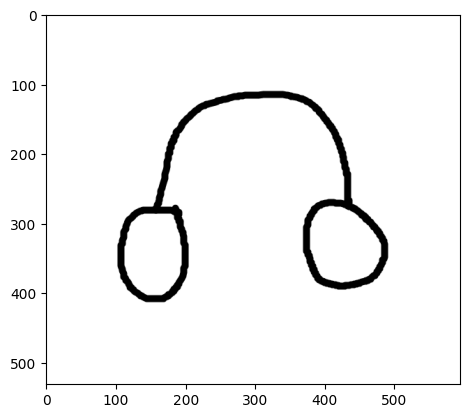

In [168]:
image_path = 'image2.png'
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=1) 
plt.imshow(image,cmap='gray')
image = tf.image.resize(image, [96, 96])
image = image / 255.0
image = tf.expand_dims(image, axis=0)
image.shape

In [169]:
prediction = (model.predict(image))
pred_class_index = np.argmax(prediction, axis=1)
label = label_encoder.inverse_transform(pred_class_index)[0]
print("Predicted Label:", label)
print(prediction*100)
print(pred_class_index)
top5 = heapq.nlargest(5, prediction)
print(top5)

top5_indices = np.argsort(prediction[0])[-5:][::-1]  
top5_probs = prediction[0][top5_indices]             
print(top5_indices)
top5_labels = label_encoder.inverse_transform(top5_indices)

for i in range(5):
    print(f"Rank {i+1}: Class = {top5_labels[i]}, Probability = {top5_probs[i]*100:.2f}%")

1/1 [==============================] - 0s 67ms/step
Predicted Label: headphones
[[8.7129773e-04 8.2812949e-05 4.5491408e-05 1.0850286e-04 7.9951067e-05
  1.1611613e-05 1.5336492e-04 3.4724413e-03 2.0787400e-05 2.1176190e-04
  4.7444200e-04 8.5280852e-05 2.9857911e-06 2.1495127e-04 8.5330603e-04
  1.0225074e-03 3.4524270e-05 1.9912179e-05 5.8502886e-03 5.3101467e-05
  7.7273245e-03 9.9056969e+01 1.1651009e-04 7.7208045e-07 3.1570144e-05
  1.8743905e-05 1.1212727e-02 6.8891044e-05 5.0290639e-04 2.6781621e-04
  4.0190748e-04 1.1189369e-03 3.0920808e-05 4.4752333e-06 4.3884930e-03
  1.0117703e-03 2.1592733e-03 5.4335498e-05 5.2180589e-05 1.6782264e-03
  3.4948581e-04 9.6325921e-06 7.2083688e-01 7.0910273e-06 2.5211944e-04
  1.7519462e-01 1.1167552e-04 5.4060755e-04 8.3319756e-04 3.8124816e-04]]
[21]
[array([8.71297743e-06, 8.28129487e-07, 4.54914073e-07, 1.08502866e-06,
       7.99510701e-07, 1.16116134e-07, 1.53364920e-06, 3.47244131e-05,
       2.07873995e-07, 2.11761903e-06, 4.74442004e

In [33]:
for images, labels in train_ds.take(1):
    print(images.shape, labels[:5])

(32, 96, 96, 1) tf.Tensor([ 2 18 37 15 14], shape=(5,), dtype=int32)


In [167]:
import joblib
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']